# Deep Learning for Audio Part 2b - Train and Predict on UrbanSound dataset

Following the pre-processing code in part 2a, we will train a neural network to achieve the state-of-art performance using a CNN. There are a few published benchmarks, and this paper [Learning from Between-class Examples for Deep Sound Recognition](https://arxiv.org/abs/1711.10282) by Tokozume et al. achieves the state-of-art result with error rate of 21.7%. 

In [1]:
# change the seed before anything else
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.set_random_seed(1)

import os
import time

import keras
keras.backend.clear_session()

import matplotlib.pyplot as plt
import sklearn

from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

from keras.layers.normalization import BatchNormalization

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

frames = 150
bands = 150
feature_size = bands * frames
num_channels = 3
data_dir = "/mnt/us8k-" + str(bands) + "bands-" + str(frames) + "frames-"+str(num_channels)+"channel"
num_labels = 10


If you're going to run this code with the full data set, this notebook assumes you've already parsed all the files and saved the numpy array to disk. We will load all the training examples (a set of 43722 examples, the first 8 folds), then use fold9 as the validation fold, and use fold 10 as the test fold.


In [3]:
# this will aggregate all the training data 
def load_all_folds(test_fold):
    assert (type(test_fold) == int)
    assert (test_fold > 0 and test_fold < 11)
    subsequent_fold = False

    train_set_range = list(range(1, 11))
    train_set_range.remove(test_fold)
    valid_fold = train_set_range.pop()

    for k in train_set_range:
        fold_name = 'fold' + str(k)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        # flip the spectrogram for each channel
        loaded_features = np.transpose(loaded_features, (0, 2, 1, 3))
        loaded_labels = np.load(labels_file)
        print("Adding ", fold_name, "New Features: ", loaded_features.shape)

        if subsequent_fold:
            train_x_loaded = np.concatenate((train_x_loaded, loaded_features))
            train_y_loaded = np.concatenate((train_y_loaded, loaded_labels))
        else:
            train_x_loaded = loaded_features
            train_y_loaded = loaded_labels
            subsequent_fold = True

    # use the penultimate fold for validation
    valid_fold_name = 'fold' + str(valid_fold)
    feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
    valid_x = np.load(feature_file)
    # flip the spectrogram for each channel
    valid_x = np.transpose(valid_x, (0, 2, 1, 3))
    valid_y = np.load(labels_file)

    # and use the last fold for testing
    test_fold_name = 'fold' + str(test_fold)
    feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
    test_x = np.load(feature_file)
    test_x = np.transpose(test_x, (0, 2, 1, 3))
    test_y = np.load(labels_file)
    return train_x_loaded, train_y_loaded, valid_x, valid_y, test_x, test_y


# Training a Convolutional Neural Network with Keras and TensorFlow

This method defines a few evaluation metrics that will be used to evaluate the performance of a trained model.

In [4]:
def evaluate(model, test_x, test_y):
    y_prob = model.predict(test_x, verbose=0)
    y_pred = np.argmax(y_prob, axis=-1)
    y_true = np.argmax(test_y, 1)

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
    print("\nAccuracy = {:.4f}".format(accuracy))
    print("\nError Rate = {:.4f}".format(1. - accuracy))

    return accuracy

We use a similar DNN architecture on featurized data as the winning solution to [DCASE 2016 Track 4](http://www.cs.tut.fi/sgn/arg/dcase2016/task-audio-tagging). DCASE is the audio challenge for sound domain and is held every year. The architecture is as below:

![CNN Architecture](https://msdnshared.blob.core.windows.net/media/2018/01/013018_0211_HearingAIGe10.png)

In [5]:
def build_model():
    model = Sequential()

    # section 1

    model.add(Convolution2D(filters=32, kernel_size=5,
                            strides=2,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal",
                            input_shape=(frames, bands, num_channels)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=32, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.3))

    # section 2    
    model.add(Convolution2D(filters=64, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=64, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # section 3
    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # section 4
    model.add(Convolution2D(filters=512, kernel_size=3,
                            strides=1,
                            padding="valid",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Convolution2D(filters=512, kernel_size=1,
                            strides=1,
                            padding="valid",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # section 5
    model.add(Convolution2D(filters=10, kernel_size=1,
                            strides=1,
                            padding="valid",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling2D())

    model.add(Activation('softmax'))

    # compile and fit model, reduce epochs if you want a result faster
    # the validation set is used to identify parameter settings (epoch) that achieves 
    # the highest classification accuracy

    return model


In [6]:
# apply scaling factor to a dataset - train, validation or test
def do_scale(x4d, verbose = True):
    """Do scale on the input sequence data.

    Args:
      x34d: ndarray, input sequence data, shape: (n_clips, n_time, n_freq, channel)      
      verbose: boolean

    Returns:
      Scaled input sequence data.
    """
    t1 = time.time()    
    (n_clips, n_time, n_freq, n_channel) = x4d.shape
    x4d_scaled = np.zeros(x4d.shape)
    for channel in range(n_channel):
        x2d = x4d[:,:,:,channel].reshape((n_clips * n_time, n_freq))
        x2d_scaled = scaler_list[channel].transform(x2d)
        x3d_scaled = x2d_scaled.reshape((n_clips, n_time, n_freq))
        x4d_scaled[:,:,:,channel] = x3d_scaled

    if verbose == 1:
        print("Scaling time: %s" % (time.time() - t1,))

    return x4d_scaled


In [7]:
# earlystopping ends training when the validation loss stops improving
model_checkpoint = ModelCheckpoint(
    './sound_classification_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5',
    monitor='val_loss', save_best_only=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks = [reduce_lr_on_plateau, early_stopping]

acc_list = []
# preliniary estimation of performance

# use this if you want to test on 10 folds and obtain standard deviation estimate
# for test_fold in range(1, 11):
# use this if you just want to test performance on one fold
for test_fold in [10]:
    keras.backend.clear_session()
    model = build_model()

    # compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adamax(0.01))

    train_x, train_y, valid_x, valid_y, test_x, test_y = load_all_folds(test_fold)

    # for each channel, compute scaling factor
    scaler_list = []
    (n_clips, n_time, n_freq, n_channel) = train_x.shape

    for channel in range(n_channel):
        t1 = time.time()
        xtrain_2d = train_x[:, :, :, channel].reshape((n_clips * n_time, n_freq))
        scaler = sklearn.preprocessing.StandardScaler().fit(xtrain_2d)
        # print("Channel %d Mean: %s" % (channel, scaler.mean_,))
        # print("Channel %d Std: %s" % (channel, scaler.scale_,))
        # print("Calculating scaler time: %s" % (time.time() - t1,))
        scaler_list += [scaler]

    train_x = do_scale(train_x)
    valid_x = do_scale(valid_x)
    test_x = do_scale(test_x)
    
    print(train_x.shape)

    # use a batch size to fully utilize GPU power
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=callbacks,
                        batch_size=256,
                        epochs=100)
    acc = evaluate(model, test_x, test_y)

    acc_list += [acc]


Adding  fold1 New Features:  (871, 150, 150, 3)
Adding  fold2 New Features:  (888, 150, 150, 3)
Adding  fold3 New Features:  (925, 150, 150, 3)
Adding  fold4 New Features:  (990, 150, 150, 3)
Adding  fold5 New Features:  (936, 150, 150, 3)
Adding  fold6 New Features:  (823, 150, 150, 3)
Adding  fold7 New Features:  (838, 150, 150, 3)
Adding  fold8 New Features:  (806, 150, 150, 3)
Scaling time: 10.063879489898682
Scaling time: 1.162663221359253
Scaling time: 1.2079789638519287
(7077, 150, 150, 3)
Train on 7077 samples, validate on 816 samples
Epoch 1/100
7077/7077 [==============================] - 38s 5ms/step - loss: 2.1648 - acc: 0.3696 - val_loss: 3.5490 - val_acc: 0.1949
Epoch 2/100
7077/7077 [==============================] - 18s 3ms/step - loss: 1.7570 - acc: 0.5155 - val_loss: 2.2811 - val_acc: 0.3603
Epoch 3/100
7077/7077 [==============================] - 18s 3ms/step - loss: 1.5269 - acc: 0.5865 - val_loss: 2.3198 - val_acc: 0.2868
Epoch 4/100
7077/7077 [====================

7077/7077 [==============================] - 18s 3ms/step - loss: 0.1878 - acc: 0.9884 - val_loss: 0.7079 - val_acc: 0.8370

Epoch 00055: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 56/100
7077/7077 [==============================] - 18s 3ms/step - loss: 0.1856 - acc: 0.9888 - val_loss: 0.7075 - val_acc: 0.8370
Epoch 57/100
7077/7077 [==============================] - 18s 3ms/step - loss: 0.1871 - acc: 0.9877 - val_loss: 0.7078 - val_acc: 0.8382
Epoch 58/100
7077/7077 [==============================] - 18s 3ms/step - loss: 0.1834 - acc: 0.9898 - val_loss: 0.7077 - val_acc: 0.8382
Epoch 59/100
7077/7077 [==============================] - 18s 3ms/step - loss: 0.1801 - acc: 0.9918 - val_loss: 0.7075 - val_acc: 0.8382
Epoch 60/100
7077/7077 [==============================] - 18s 3ms/step - loss: 0.1850 - acc: 0.9895 - val_loss: 0.7065 - val_acc: 0.8382

Epoch 00060: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 61/100
7077/7077 [======================

In [8]:
acc_array = np.array(acc_list)
print("acc mean %.4f acc std %.4f" % (acc_array.mean(), acc_array.std()))

acc mean 0.8375 acc std 0.0000


837/837 [==============================] - 1s 1ms/step

Accuracy = 0.8375

Error Rate = 0.1625
Showing Confusion Matrix
                    air conditioner            horn        children             dog           drill          engine             gun          hammer           siren           music 
    air conditioner              81               0              10               0               1               6               0               0               0               2 
               horn               0              29               0               0               0               0               0               0               0               4 
           children               0               0              91               1               0               0               0               0               2               6 
                dog               0               2               7              78               4               0               0               4         

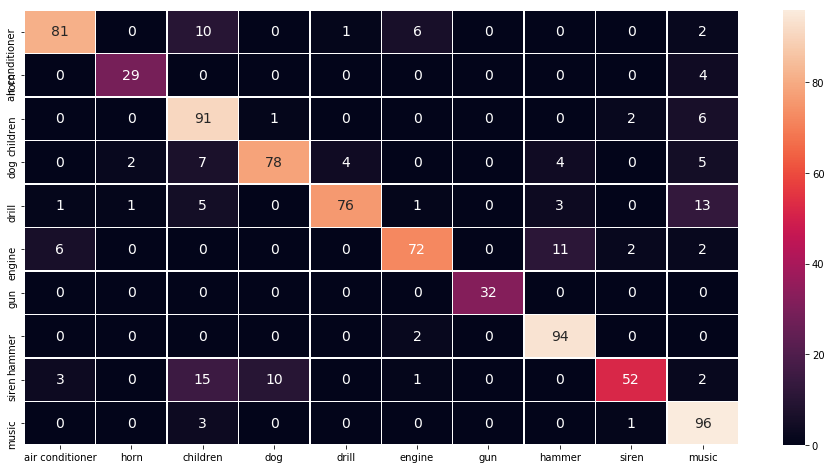

In [9]:
% matplotlib inline
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

#model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], batch_size=32, nb_epoch=50)
acc = evaluate(model, test_x, test_y)  #evaluate(model)

labels = ["air conditioner", "horn", "children", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
print("Showing Confusion Matrix")
y_prob = model.predict(test_x, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=' ')
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=' ')
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=' ')
        print()

print_cm(cm, labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(16, 8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)


History keys: dict_keys(['lr', 'val_acc', 'loss', 'val_loss', 'acc'])


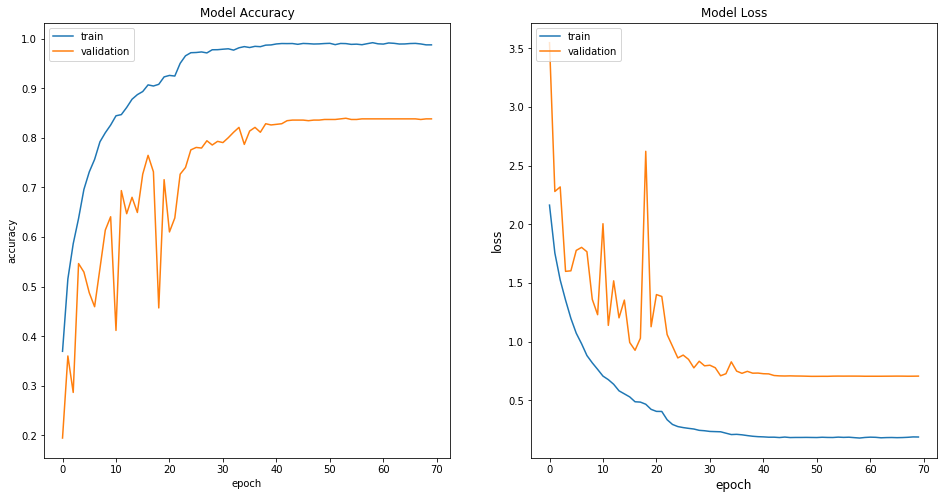

In [10]:
fig = plt.figure(figsize=(16,8))

print("History keys:", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss', fontsize = 'large')
plt.xlabel('epoch', fontsize = 'large' )
plt.legend(['train', 'validation'], loc='upper left')
plt.show()